In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install psynlig

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
# Ignore Warning message
import warnings
warnings.filterwarnings('ignore')

# Random seed fix
import os
import random

# loading
from tqdm import tqdm

# progress bar in repeated code

import pandas as pd
import numpy as np

# preprocessing
from sklearn.preprocessing import LabelEncoder

# Impute
from sklearn.impute import KNNImputer

# Visualization
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')
# plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from psynlig import plot_correlation_heatmap
import seaborn as sns
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)  # 한글폰트를 사용하며 마이너스폰트가 깨져 이렇게 설정
%config InlineBackend.figure_format = 'retina' # 폰트 선명하게 보이기 위해

# Validation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Scoring
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error

# Model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm
import xgboost
import catboost

In [ ]:
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'  # 설치한 한글 폰트 파일 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['font.size'] = 12  # 원하는 폰트 크기로 설정

In [ ]:
# Seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37)

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/DACON/train.csv').drop('ID',axis  = 1)
test = pd.read_csv('/content/drive/MyDrive/DACON/test.csv').drop('ID',axis = 1)

In [ ]:
train

,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격
0,2018,2014,skoda,fabia,KAT,SLA,85231,999,0,0,1,0,0,51.74
1,2010,2006,toyota,auris,RKO,SWI,135000,1598,0,0,1,0,0,41.47
2,2002,2002,mercedes-benz,clk-klasa,GNI,WIE,255223,1796,0,0,1,0,0,17.81
3,2006,2001,nissan,x-trail,EHX,WIE,238000,2184,0,1,0,0,0,18.20
4,2007,2007,fiat,bravo,OSW,MAL,251000,1910,0,1,0,0,0,17.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57915,2017,2011,mercedes-benz,b-klasa,POZ,WIE,64839,1461,0,1,0,0,0,116.87
57916,2006,2005,opel,zafira,XOK,ZAC,299850,1796,0,0,1,0,0,15.47
57917,2013,2003,fiat,punto,CIE,MAZ,112000,1368,0,0,1,0,0,21.97
57918,2006,2004,opel,astra,ZRI,DOL,189321,1598,0,0,1,0,0,16.77


In [ ]:
count = len(train[train['주행거리'] >= 300000])
print("300000 이상인 경우의 개수:", count)

300000 이상인 경우의 개수: 2993


In [ ]:
train = train[train['주행거리'] < 300000]

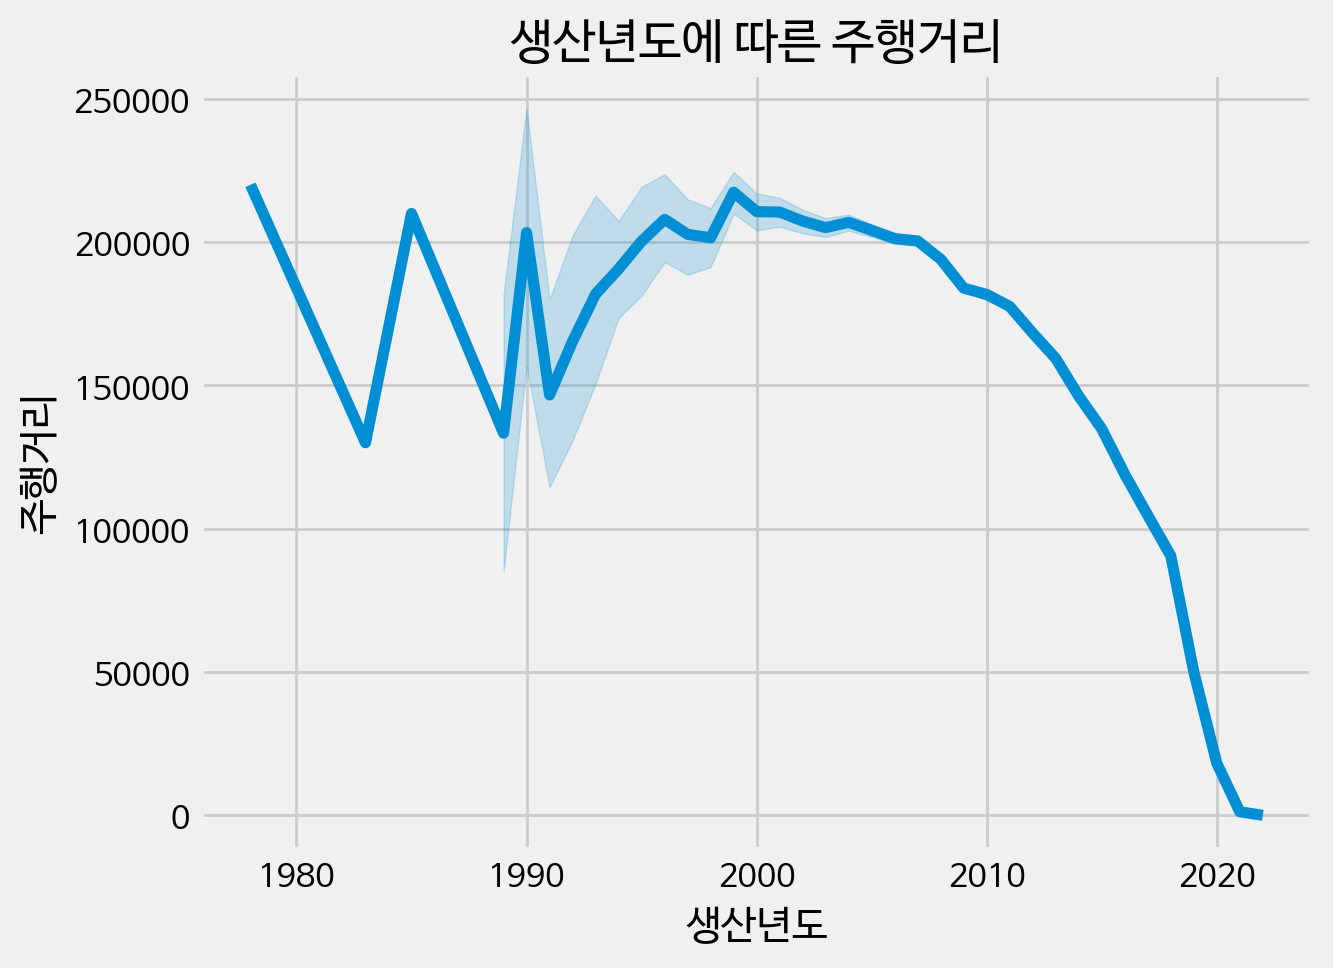

In [ ]:
train['주행거리_구간'] = np.floor(train['주행거리'] / 10000) * 10000

sns.lineplot(data=train, x='생산년도', y='주행거리_구간')
plt.xlabel('생산년도')
plt.ylabel('주행거리')
plt.title('생산년도에 따른 주행거리')
plt.show()

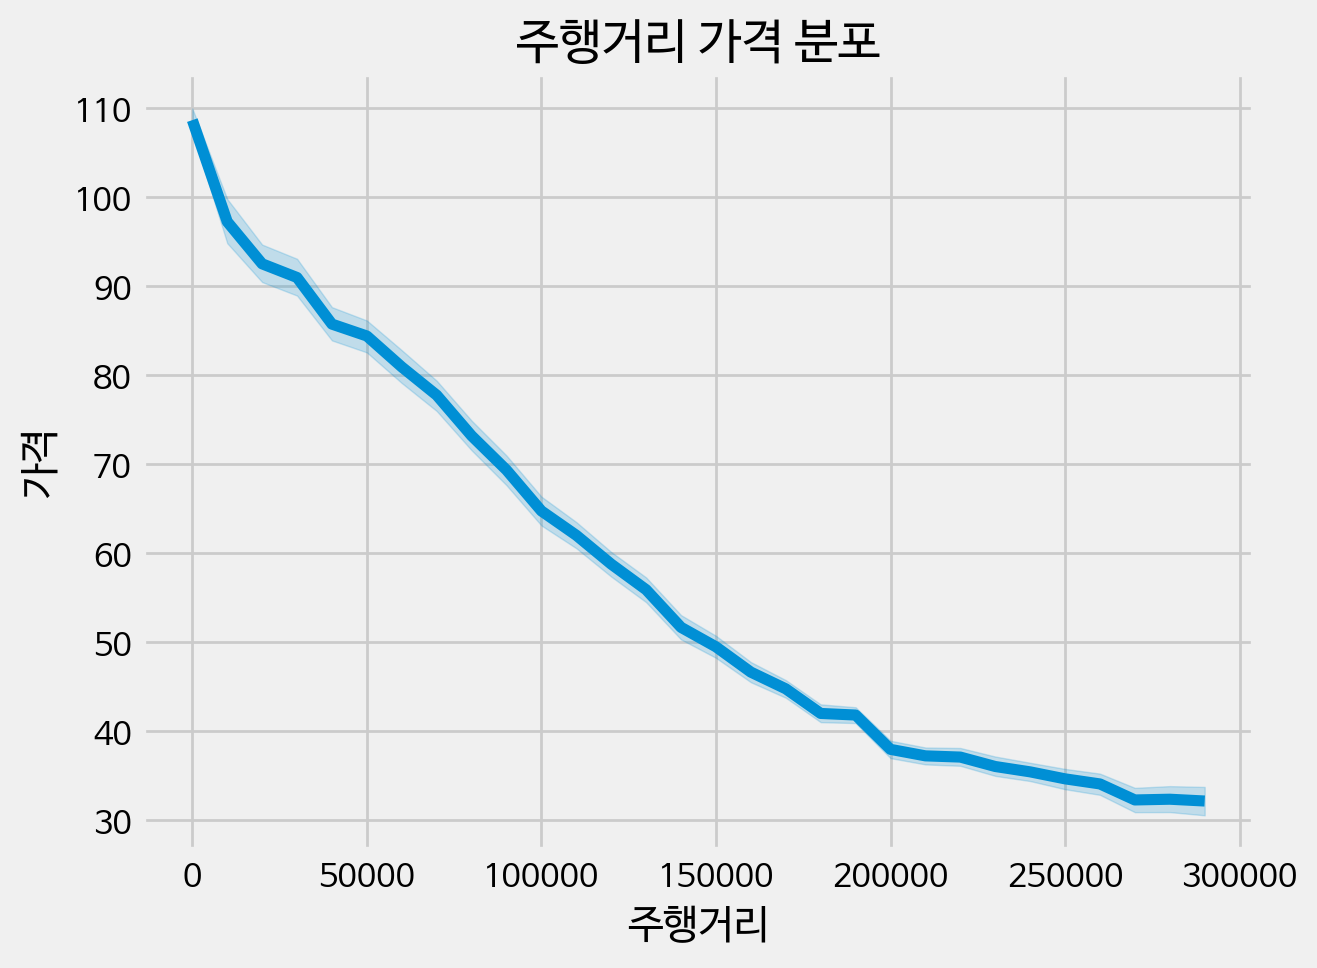

In [ ]:
train = train[train['주행거리'] < 2500000]
train['주행거리_구간'] = np.floor(train['주행거리'] / 10000) * 10000

sns.lineplot(data=train, x='주행거리_구간', y='가격')
plt.xlabel('주행거리')
plt.ylabel('가격')
plt.title('주행거리 가격 분포')
plt.show()

In [ ]:
count = len(train[train['생산년도'] <= 2000])
print("1990년도 미만 생산:", count)

1990년도 미만 생산: 821


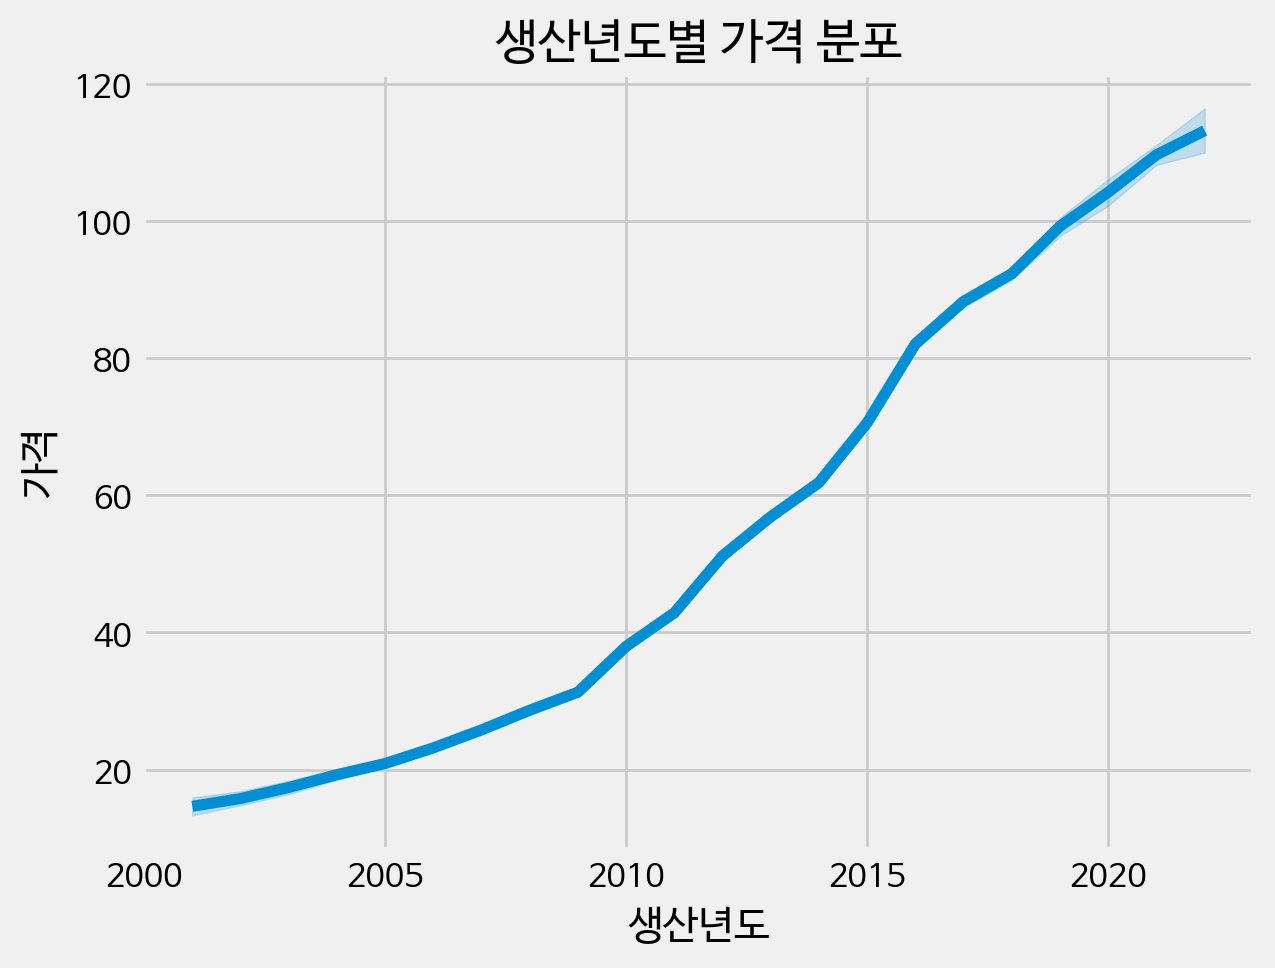

In [ ]:
train = train[train['생산년도'] > 2000]
sns.lineplot(data=train, x='생산년도', y='가격')
plt.xlabel('생산년도')
plt.ylabel('가격')
plt.title('생산년도별 가격 분포')
plt.show()

In [ ]:
count = len(train[train['모델출시년도'] <= 1990])
print("1990년도 미만 생산:", count)

1990년도 미만 생산: 2


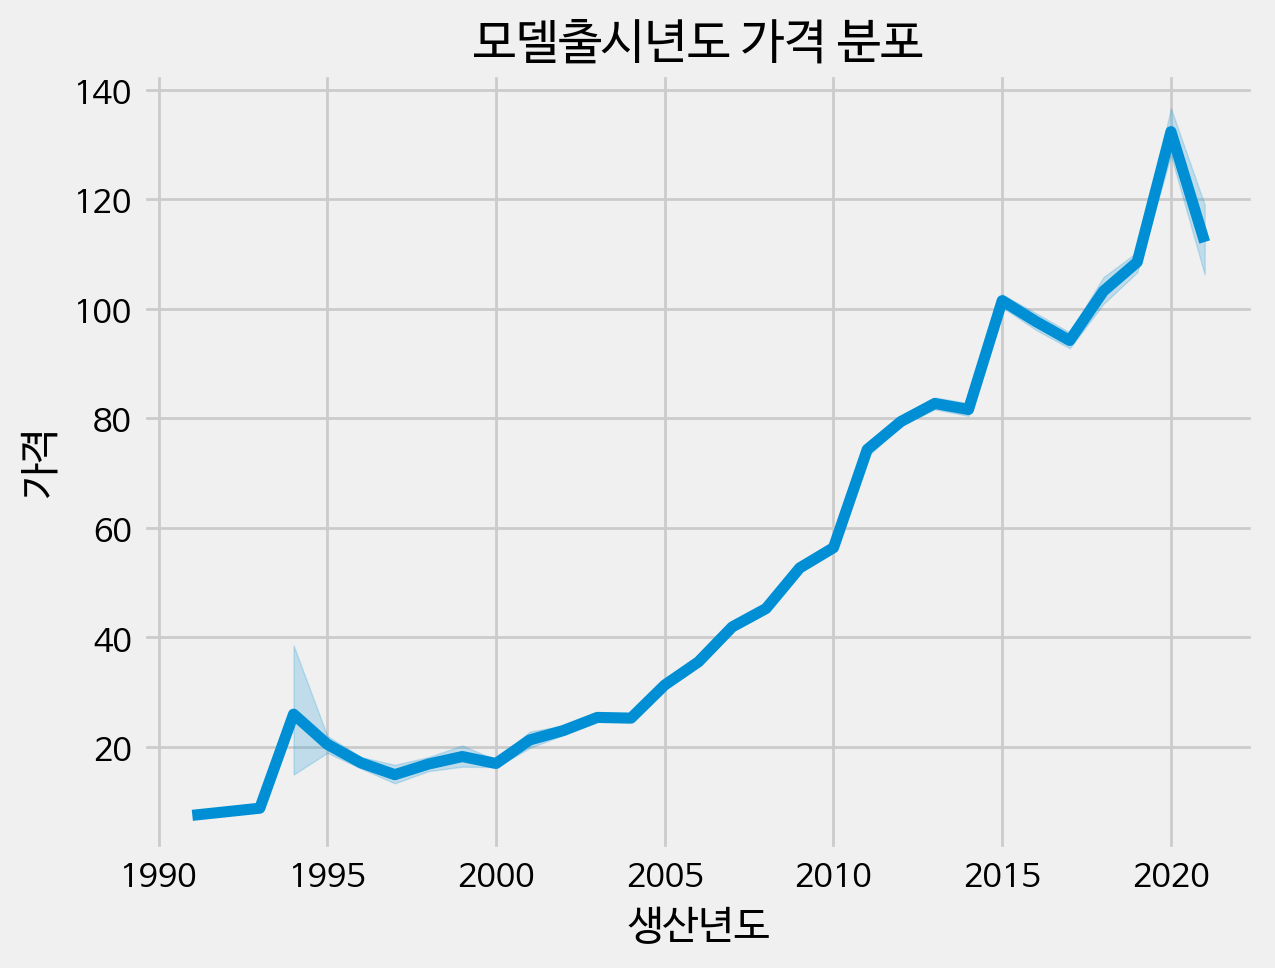

In [ ]:
train = train[train['모델출시년도'] > 1990]
sns.lineplot(data=train, x='모델출시년도', y='가격')
plt.xlabel('생산년도')
plt.ylabel('가격')
plt.title('모델출시년도 가격 분포')
plt.show()

In [ ]:
train # 57768개의 rows에서 약 3600개의 rows가 줄어듦

,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격,주행거리_구간
0,2018,2014,skoda,fabia,KAT,SLA,85231,999,0,0,1,0,0,51.74,80000.0
1,2010,2006,toyota,auris,RKO,SWI,135000,1598,0,0,1,0,0,41.47,130000.0
2,2002,2002,mercedes-benz,clk-klasa,GNI,WIE,255223,1796,0,0,1,0,0,17.81,250000.0
3,2006,2001,nissan,x-trail,EHX,WIE,238000,2184,0,1,0,0,0,18.20,230000.0
4,2007,2007,fiat,bravo,OSW,MAL,251000,1910,0,1,0,0,0,17.55,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57915,2017,2011,mercedes-benz,b-klasa,POZ,WIE,64839,1461,0,1,0,0,0,116.87,60000.0
57916,2006,2005,opel,zafira,XOK,ZAC,299850,1796,0,0,1,0,0,15.47,290000.0
57917,2013,2003,fiat,punto,CIE,MAZ,112000,1368,0,0,1,0,0,21.97,110000.0
57918,2006,2004,opel,astra,ZRI,DOL,189321,1598,0,0,1,0,0,16.77,180000.0


In [ ]:
### Label Encoding
ordinal_features = ['브랜드', '차량모델명', '판매도시', '판매구역']

for feature in ordinal_features:
    le = LabelEncoder()
    le = le.fit(train[feature])
    train[feature] = le.transform(train[feature])

    # train데이터에서 존재하지 않았던 값이 test 데이터에 존재할 수도 있습니다.
    # 따라서 test 데이터를 바로 변형시키지 않고 고유값을 확인후 test 데이터를 변환합니다.
    # Data Leakage를 발생시키지 않기 위함이니, 반드시 주의해주세요.
    for label in np.unique(test[feature]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test[feature] = le.transform(test[feature])

In [ ]:
train_x, train_y = train.drop(columns=['가격', '주행거리_구간']), train['가격']
test = test[train_x.columns]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 객체 생성 및 훈련 데이터에 맞게 적합화
scaler = MinMaxScaler()
scaler.fit(train_x)

# 훈련 데이터와 테스트 데이터에 대해 정규화 수행
train_x = scaler.transform(train_x)
test = scaler.transform(test)


In [ ]:
# train_x = train_x.values
train_y = train_y.values
# test = test.values

In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

model = catboost.CatBoostRegressor()

mae_scores = []

# 교차 검증 수행
for train_index, test_index in kfold.split(train_x):
    X_train, X_test = train_x[train_index], train_x[test_index]
    y_train, y_test = train_y[train_index], train_y[test_index]


    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

# MAE의 평균 계산
average_mae = sum(mae_scores) / len(mae_scores)
print("Average MAE:", average_mae) #5.677(kfold만)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
5:	learn: 26.6062336	total: 36.3ms	remaining: 6.01s
6:	learn: 25.5191303	total: 41.7ms	remaining: 5.92s
7:	learn: 24.5137763	total: 47.6ms	remaining: 5.9s
8:	learn: 23.5790489	total: 53.4ms	remaining: 5.88s
9:	learn: 22.7650200	total: 59.1ms	remaining: 5.85s
10:	learn: 22.0092597	total: 64.3ms	remaining: 5.78s
11:	learn: 21.3009580	total: 69.9ms	remaining: 5.76s
12:	learn: 20.6714191	total: 77.6ms	remaining: 5.89s
13:	learn: 20.0681438	total: 87.9ms	remaining: 6.19s
14:	learn: 19.5364342	total: 93.6ms	remaining: 6.14s
15:	learn: 19.0560604	total: 99.8ms	remaining: 6.14s
16:	learn: 18.5994112	total: 105ms	remaining: 6.09s
17:	learn: 18.2018074	total: 111ms	remaining: 6.06s
18:	learn: 17.8286495	total: 117ms	remaining: 6.02s
19:	learn: 17.4698377	total: 122ms	remaining: 5.98s
20:	learn: 17.1711479	total: 128ms	remaining: 5.95s
21:	learn: 16.8794924	total: 133ms	remaining: 5.93s
22:	learn: 16.6246488	total: 139ms	remaining: 5.89s
23:	learn: 16.3935028	t

In [ ]:
r_estimators = [('lgbm', lightgbm.LGBMRegressor()),
              ('catb', catboost.CatBoostRegressor(verbose=0, task_type='GPU')),
              ('xgb', xgboost.XGBRegressor()),
              ('lr', LinearRegression()),
              ('ef', ExtraTreesRegressor()),
              ]

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

model = clf = StackingRegressor(estimators=r_estimators, final_estimator=LinearRegression(), cv=6)

mae_scores = []

# 교차 검증 수행
for train_index, test_index in kfold.split(train_x):
    X_train, X_test = train_x[train_index], train_x[test_index]
    y_train, y_test = train_y[train_index], train_y[test_index]


    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

# MAE의 평균 계산
average_mae = sum(mae_scores) / len(mae_scores)
print("Average MAE:", average_mae)
#5.8978(스태킹시) #5.8942(<-에 sc까지 할 시 근데 값이 이상함.) 5.8923(정규화) 그냥 스태킹이 가장 좋았다. 정규화한게 MAE는 가장 좋음
# 5.857(1995년 이상만 수행)

Average MAE: 5.9965405431914505


In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/DACON/sample_submission.csv')
pred = model.predict(test)
submit['가격'] = pred
submit.to_csv('/content/drive/MyDrive/DACON/sample_submission.csv', index=False)
print('Done')

Done


In [ ]:
pred

array([ 85.11661516,  24.57852072,  83.63756837, ..., 105.26799888,
        50.71825518,  38.76487999])